In [1]:
import os
import re
import glob
import json
import subprocess
import soundfile as sf
import argparse

import pandas as pd
import numpy as np
import librosa
import scipy.io.wavfile
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from functools import partial

from sklearn.model_selection import StratifiedKFold, train_test_split

import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

main_dir = r"Datasets\TIMIT-dataset\data"

# Preprocessing

Max frames: 124621


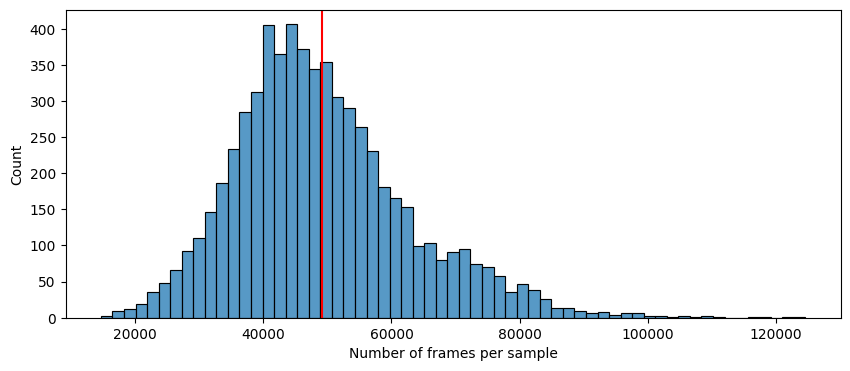

In [2]:
wav_paths = [path for path in glob.glob(main_dir + "/*/*/*.wav") 
    if not (path.endswith("_1.wav") or path.endswith("_2.wav"))]
frames = [len(librosa.load(wav_path, sr=16000)[0]) for wav_path in wav_paths]
print("Max frames:", np.max(frames))

plt.figure(figsize=(10,4))
sns.histplot(data=frames)
plt.axvline(x=np.mean(frames), color='red')
plt.xlabel("Number of frames per sample")
plt.show()

## Clip non-verbal units

In [17]:
def Clip(wav_paths, clip_buffer=320):
    for wav_path in tqdm(wav_paths, desc='Clip'):
        phn_path = wav_path.replace(".wav", ".phn")
        lines = open(phn_path, "r").readlines()
        y = librosa.load(wav_path, sr=16000)[0]
        y_1 = len(y)

        # First line
        start, end, phoneme = lines[0].split()
        if phoneme == "h#":
            if int(end) > clip_buffer:
                clip_factor = int(end) - clip_buffer
                y = y[clip_factor::]
                for i, line in enumerate(lines):
                    start, end, phoneme = line.split()
                    start = int(start) - clip_factor
                    end = int(end) - clip_factor
                    lines[i] = f"{max(0, start)} {end} {phoneme}\n"

        # Middle lines
        phonemes = np.array([line.split()[-1] for line in lines])
        cond = (phonemes == "pau") | (phonemes == "sil") | (phonemes == "epi")
        for i in np.where(cond)[0]:
            start, end, phoneme = lines[i].split()
            start, end = int(start), int(end)
            delta = end - start
            clip_factor = delta - clip_buffer
            if delta >= clip_buffer:
                new_end = int(end) - clip_factor
                lines[i] = f"{start} {new_end} {phoneme}\n"
                y = np.concatenate((y[:new_end], y[end:]), axis=0)
                for j in range(i+1, len(lines)):
                    start, end, phoneme = lines[j].split()
                    start = int(start) - clip_factor
                    end = int(end) - clip_factor
                    lines[j] = f"{start} {end} {phoneme}\n"

        # Last line
        start, end, phoneme = lines[-1].split()
        if phoneme == "h#":
            delta = int(end) - int(start)
            if delta > clip_buffer:
                end = int(start) + clip_buffer
                lines[-1] = f"{start} {end} {phoneme}\n"
                y = y[:end]
    
        with open(phn_path, "w") as f:
            f.writelines(lines)

        sf.write(wav_path, y, 16000)    

Clip(wav_paths)

Clip:   0%|          | 0/6300 [00:00<?, ?it/s]

Max frames: 106287


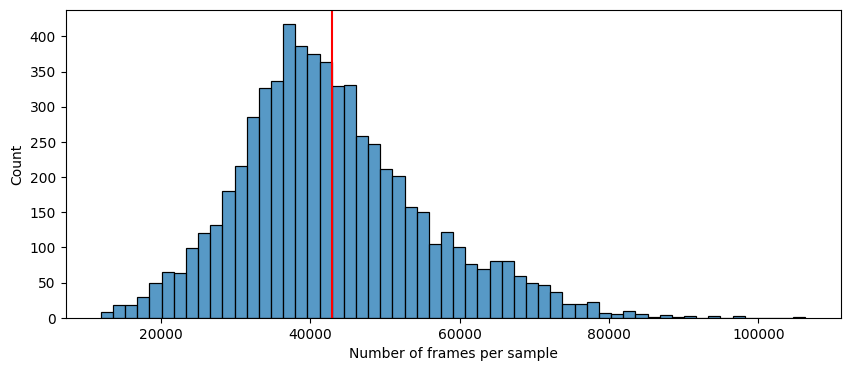

In [18]:
wav_paths = [path for path in glob.glob(main_dir + "/*/*/*.wav") 
    if not (path.endswith("_1.wav") or path.endswith("_2.wav"))]
frames = [len(librosa.load(wav_path, sr=16000)[0]) for wav_path in wav_paths]
print("Max frames:", np.max(frames))

plt.figure(figsize=(10,4))
sns.histplot(data=frames)
plt.axvline(x=np.mean(frames), color='red')
plt.xlabel("Number of frames per sample")
plt.show()

## Split

In [27]:
def Split(wav_paths):
    cutoff_limit = 60000
    split_files, frames = [], []
    for wav_path in tqdm(wav_paths, desc='Split'):
        y = librosa.load(wav_path, sr=16000)[0]
        n_frames = len(y)
        frames.append(n_frames)
        if n_frames >= cutoff_limit:
            phn_path = wav_path.replace("wav", "phn")
            lines = open(phn_path, "r").readlines()
            end = np.array([int(line.split()[1]) for line in lines])
            mid_point = n_frames // 2
            idx = np.where(end <= mid_point)[0][-1]
            lines_1 = lines[:idx]
            lines_2 = lines[idx:]
            factor = int(lines_2[0].split()[0])
            for i, line in enumerate(lines_2):
                start, end, phoneme = line.split()
                start = int(start) - factor
                end = int(end) - factor
                line = " ".join([str(start), str(end), phoneme + "\n"])
                lines_2[i] = line
            f1_path = os.path.splitext(phn_path)[0] + "_1.phn"
            f2_path = os.path.splitext(phn_path)[0] + "_2.phn"
            if (len(y[:factor]) > cutoff_limit) | (len(y[factor:]) > cutoff_limit):
                print(lines_1, lines_2)
            for path, lines in zip([f1_path, f2_path], [lines_1, lines_2]):
                with open(path, "w") as f:
                    f.writelines(lines)    
            sf.write(f1_path.replace("phn", "wav"), y[:factor], 16000)
            sf.write(f2_path.replace("phn", "wav"), y[factor:], 16000)
            split_files.append(wav_path)

    print("Number of splitted files:", len(split_files))
    return split_files

split_files = Split(wav_paths)

Split:   0%|          | 0/6300 [00:00<?, ?it/s]

Number of splitted files: 652


Number of files: 6952
Max frames: 59999
Dropped files:
 []


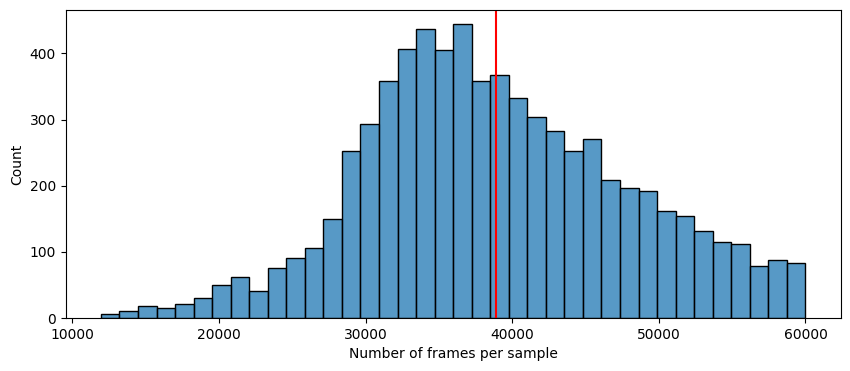

In [28]:
wav_paths = glob.glob(main_dir + "/*/*/*.wav")
wav_paths = [path for path in wav_paths if not path in split_files]
frames = []
for wav_path in wav_paths:
    y = librosa.load(wav_path, sr=16000)[0]
    n_frames = len(y)
    frames.append(n_frames)

pd.DataFrame({'wav_paths': wav_paths}).to_csv("Datasets\TIMIT-dataset\data.csv", index=False)

print("Number of files:", len(wav_paths))
print("Max frames:", np.max(frames))
plt.figure(figsize=(10, 4))
sns.histplot(data=frames)
plt.axvline(x=np.mean(frames), color='red')
plt.xlabel("Number of frames per sample")
plt.show()

## Padding

In [ ]:
# wav_paths = glob.glob(main_dir + "/*/*/*.wav")
# wav_paths = [path for path in wav_paths if not path in split_files]
    
# for wav_path in tqdm(wav_paths, desc='Padding'):
#     y = librosa.load(wav_path, sr=16000)[0]
#     n_frames = len(y)
#     y_sil = np.array([])
#     if n_frames != cutoff_limit:
#         pad_length = cutoff_limit - n_frames

#         with open(wav_path.replace("wav", "phn"), "r") as f:
#             lines = f.readlines()
#         phonemes = np.array([line.split()[-1] for line in lines])
#         for i in np.where(phonemes == "h#")[0]:
#             start_sil, end_sil = list(map(int, lines[i].split()[:-1]))
#             y_sil = np.concatenate([y_sil, y[start_sil:end_sil]])
        
#         if len(y_sil) >= pad_length:
#             y_sil = y_sil[:pad_length]
#         else:
#             extension = pad_length - len(y_sil)
#             y_sil = np.pad(y_sil, (0, extension), mode='wrap')
        
#         np.random.shuffle(y_sil)
#         y = np.concatenate([y, y_sil])
        
#         start, end, phoneme = lines.pop(-1).split()
#         if lines[-1].split()[-1] == "h#":
#             line = " ".join([end, str(cutoff_limit), phoneme])
#         else:
#             line = " ".join([start, str(cutoff_limit), "h#\n"])
#         lines.append(line)

#         with open(wav_path.replace("wav", "phn"), "w") as f:
#             f.writelines(lines)

#         sf.write(wav_path, y, 16000)

#     else:
#         pass

In [29]:
d = pd.read_csv("Datasets\TIMIT-dataset\data.csv")
d

,wav_paths
0,Datasets\TIMIT-dataset\data\DR1\FAKS0\SA1.wav
1,Datasets\TIMIT-dataset\data\DR1\FAKS0\SA2.wav
2,Datasets\TIMIT-dataset\data\DR1\FAKS0\SI1573_1...
3,Datasets\TIMIT-dataset\data\DR1\FAKS0\SI1573_2...
4,Datasets\TIMIT-dataset\data\DR1\FAKS0\SI2203.wav
...,...
6947,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX172.wav
6948,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX262.wav
6949,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX352.wav
6950,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX442.wav


# TFrecords

## Write

In [ ]:
def ArgParser():
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--n_splits", dest="n_splits", type=int, default=5)
    parser.add_argument("--sample_rate", dest="sample_rate", type=int, default=16000)
    parser.add_argument("--n_fft", dest="n_fft", type=int, default=2048)
    parser.add_argument("--window_size", dest="window_size", type=int, default=480)
    parser.add_argument("--hop_length", dest="hop_length", type=int, default=160) # 160 samples = 10ms
    parser.add_argument("--n_mels", dest="n_mels", type=int, default=32)
    parser.add_argument("--batch_size", dest="batch_size", type=int, default=16)
    parser.add_argument("--buffer_size", dest="buffer_size", type=int, default=512)
    parser.add_argument("--max_samples", dest="max_samples", type=int, default=67200)
    parser.add_argument("--main_dir", dest='main_dir', type=str, default="Datasets/TIMIT-dataset/tfrec_data")

    
    args = parser.parse_known_args()[0]
    seq_len = int(np.ceil(args.max_samples / args.hop_length))
    parser.add_argument("--seq_len", type=int, default=seq_len)
    return parser.parse_known_args()[0]

args = ArgParser()
args

In [ ]:
class TFRWriter():
    def __init__(self, args):
        self.samples = d['wav_paths'].tolist()
        self.args = args
        self.dict_path = "Datasets\TIMIT-dataset\phoneme_dict.json"
        self.phoneme_dict = self.get_dict()

    def _bytes_feature(self, value):
        """Returns a bytes_list from a string / byte."""
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def _int64_feature(self, value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

    def serialize_example(self, *args):
        feature = {
            'audio': self._bytes_feature(args[0]),
            'binary_labels': self._bytes_feature(args[1]),
            'framewise_labels': self._bytes_feature(args[2]),
            'attention_mask': self._bytes_feature(args[3]),
            'true_length': self._int64_feature(args[4]),
            'filename': self._bytes_feature(args[5])}

        example_proto = tf.train.Example(
            features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

    def get_binary_labels(self, p_frames):
        p_frames = tf.convert_to_tensor(p_frames)
        labels = tf.tensor_scatter_nd_update(
            tensor=tf.zeros([p_frames[-1]+1], dtype=tf.int32), 
            indices=tf.expand_dims(p_frames, axis=1), 
            updates=tf.ones([p_frames.shape[0]], dtype=tf.int32))
        padding = tf.zeros([self.args.seq_len-len(labels)], dtype=tf.int32)
        return tf.concat([labels, padding], axis=0)

    def get_framewise_labels(self, p_frames, phonemes):
        labels = []
        for i in range(1, len(p_frames)):
            for j in range(p_frames[i-1], p_frames[i]):
                labels.append(phonemes[i-1])
        labels = tf.convert_to_tensor(labels)
        padding = tf.zeros([self.args.seq_len-len(labels)], dtype=tf.int32)
        return tf.concat([labels, padding], axis=0)

    def get_attention_mask(self, p_frames):
        mask = tf.convert_to_tensor(
            [True if i < p_frames[-1] else False for i in range(self.args.seq_len)])
        return mask

    def get_shards(self):
        speaker_id = [sample.split('\\')[4] for sample in self.samples]
        skf = StratifiedKFold(
            n_splits=self.args.n_splits, shuffle=True, random_state=42)
        return [
            list(map(lambda x: self.samples[x], j)) 
            for i, j in skf.split(self.samples, speaker_id)]

    def get_dict(self):
        phonemes = set()
        markers = ['h#', 'pau', 'epi']
        for sample in self.samples:
            base_path = os.path.splitext(sample)[0]
            with open(base_path + '.phn', "r") as f:
                for line in f.readlines():
                    phoneme = line.split()[-1]
                    if not phoneme in markers:
                        phonemes.add(phoneme)
        phonemes = markers + sorted(Counter(phonemes), key=Counter(phonemes).get, reverse=True)
        phonemes_dict = {v: i+1 for i, v in enumerate(phonemes)}
        with open(self.dict_path, "w") as f:
            json.dump(phonemes_dict, f, sort_keys=False, indent=4)
        return phonemes_dict 
    
    def get_shard_data(self, samples, shard):
        for sample in tqdm(
                samples, total=len(samples), desc=f"Writing shard {shard}"):
            base_path = os.path.splitext(sample)[0]
            p_frames, phonemes = [0], []
            with open(base_path + ".phn") as f:
                for line in f.readlines():
                    p_frame, phoneme = line.split()[1::]
                    p_frames.append(int(p_frame) // self.args.hop_length)
                    phonemes.append(str(phoneme))
            phonemes = list(map(self.phoneme_dict.get, phonemes))
            binary_labels = self.get_binary_labels(p_frames)
            framewise_labels = self.get_framewise_labels(p_frames, phonemes)
            waveform = tf.io.read_file(base_path + ".wav")
            spec_mask = self.get_attention_mask(p_frames)
            filename = str.encode("/".join(sample.split('\\')[-3::]))
            yield {
                "audio": waveform,
                "binary_labels": tf.io.serialize_tensor(binary_labels),
                "framewise_labels": tf.io.serialize_tensor(framewise_labels),
                "attention_mask": tf.io.serialize_tensor(spec_mask),
                "true_length": p_frames[-1],
                "filename": filename}

    def write(self):
        for shard, samples in enumerate(self.get_shards()):
            with tf.io.TFRecordWriter(
                    f"Datasets/TIMIT-dataset/tfrec_data/train_{shard+1}.tfrec") as f:
                for sample in self.get_shard_data(samples, shard+1):
                    example = self.serialize_example(
                        sample['audio'], sample['binary_labels'], 
                        sample['framewise_labels'], sample['attention_mask'],
                        sample['true_length'], sample['filename'])
                    f.write(example)

TFRWriter(args).write()

## Loading

In [ ]:
class TIMITDataset():
    def __init__(self, args):
        self.files = [os.path.join(args.main_dir, f) for f in os.listdir(args.main_dir)]
        self.args = args
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.train_files, self.val_files = train_test_split(
            self.files, test_size=0.2, shuffle=True)

    def decode_audio(self, string):
        audio = tf.audio.decode_wav(string, desired_samples=self.args.max_samples)[0]
        return tf.squeeze(audio, axis=-1)

    def read_tfrecord(self, example):
        feature_description = {
            'audio': tf.io.FixedLenFeature([], tf.string),
            'binary_labels': tf.io.FixedLenFeature([], tf.string),
            'attention_mask': tf.io.FixedLenFeature([], tf.string)}
        
        example = tf.io.parse_single_example(example, feature_description)
        example['audio'] = self.decode_audio(example['audio'])
        example['binary_labels'] = tf.io.parse_tensor(
            example['binary_labels'], out_type=tf.int32)
        example['attention_mask'] = tf.io.parse_tensor(
            example['attention_mask'], out_type=tf.bool)
        example['binary_labels'] = tf.cast(example['binary_labels'], dtype=tf.float32)
        return example

    def load_dataset(self, files):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.map(self.read_tfrecord, num_parallel_calls=self.AUTOTUNE)
        return dataset
 
    def SpecAugment(self, sample, training):
        waveform = sample['audio'] / 32678
        if training == True:
            waveform = tfio.audio.fade(
                waveform, fade_in=1000, fade_out=2000, mode="logarithmic")
        spectrogram = tf.abs(tfio.audio.spectrogram(
            waveform, nfft=self.args.n_fft, window=self.args.window_size, 
            stride=self.args.hop_length))
        mel_spectrogram = tfio.audio.melscale(
            spectrogram, rate=self.args.sample_rate, mels=self.args.n_mels, 
            fmin=0, fmax=8000)
        mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
        if training == True:
            mel_spectrogram = tfio.audio.freq_mask(mel_spectrogram, param=7)
            mel_spectrogram = tfio.audio.time_mask(mel_spectrogram, param=10)
        inputs = {"spectrogram": mel_spectrogram, "mask": sample['attention_mask']}
        return inputs, sample['binary_labels']

    def train(self):
        dataset = self.load_dataset(self.train_files)
        dataset = dataset.map(
            partial(self.SpecAugment, training=True), num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.shuffle(self.args.buffer_size)
        dataset = dataset.batch(self.args.batch_size)
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

    def val(self):
        dataset = self.load_dataset(self.val_files)
        dataset = dataset.map(
            partial(self.SpecAugment, training=False), num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.batch(self.args.batch_size)
        dataset = dataset.cache()
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

train = TIMITDataset(args).train()
val = TIMITDataset(args).val()
train

In [ ]:
mask = next(iter(train))[0]['mask']
mask

## SpecAugment

In [ ]:
import librosa.display

spectrogram, mask = next(iter(train))[0].values()

plt.figure(figsize=(10, 7))
n_samples = spectrogram.shape[0]
row = 4; col = int(n_samples / 4)

for i in range(n_samples):
    plt.subplot(row, col, i+1)
    plt.axis("off")
    librosa.display.specshow(spectrogram[i].numpy().T)

plt.tight_layout()
plt.show()

In [ ]:
def Segmentor(input_shape=(420, 32), dropout=0.2):
    spectrogram = Input(shape=input_shape, dtype=tf.float32, name='spectrogram')
    mask = Input(shape=input_shape[0], dtype=tf.bool, name='mask')
    layer_1 = Bidirectional(LSTM(50, dropout=dropout, return_sequences=True), name="layer_1")
    layer_2 = Bidirectional(LSTM(25, dropout=dropout, return_sequences=True), name="layer_2")
    layer_3 = TimeDistributed(Dense(1, activation='sigmoid', name='layer_3'))

    x = layer_1(inputs=spectrogram, mask=mask)
    x = layer_2(x)
    x = layer_3(x)
    outputs = tf.squeeze(x, axis=-1)
    return Model(inputs=[spectrogram, mask], outputs=outputs, name='Segmentor')

model = Segmentor()
# model.summary()

plot_model(model, show_shapes=True, show_layer_names=False, show_dtype=True)

In [ ]:
class WeightedBinaryCrossentropy(tf.keras.losses.Loss):
    def __init__(
            self, from_logits=False, label_smoothing=0, 
            axis=-1, factor=2, name='weighted_bce'):
        super(WeightedBinaryCrossentropy, self).__init__()
        self.factor = factor      
    
    def __call__(self, y_true, y_pred, sample_weight=None):
        loss = tf.nn.weighted_cross_entropy_with_logits(
            labels=y_true, logits=y_pred, pos_weight=self.factor)
        return tf.math.reduce_mean(loss)

In [ ]:
epochs = 10
# loss_fn = WeightedBinaryCrossentropy(from_logits=True, factor=2)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False, axis=-1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)
train_metric = tf.keras.metrics.MeanIoU(num_classes=2, name='jaccard')
val_metric = tf.keras.metrics.MeanIoU(num_classes=2, name='jaccard')

for epoch in range(epochs):
    for step, (X_train, y_train) in tqdm(enumerate(train), total=350):
        mask = tf.cast(X_train['mask'], dtype=tf.float32)
        with tf.GradientTape() as tape:
            logits = model(X_train, training=True)
            loss = loss_fn(y_train, logits)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        train_metric.update_state(y_train, logits, sample_weight=mask)

    jaccard = train_metric.result()
    train_metric.reset_states()
    
    for X_val, y_val in val:
        mask = X_val['mask']
        val_logits = model(X_val, training=False)
        val_loss = loss_fn(y_val, val_logits)
        val_metric.update_state(y_val, val_logits, sample_weight=mask)
    
    val_jaccard = val_metric.result()
    val_metric.reset_states()

    print("Epoch {}: - loss: {:.3f} - jaccard: {:.2f}% - val_loss: {:.3f} - val_jaccard: {:.2f}%".format(
        epoch, loss, jaccard.numpy()*100, val_loss, val_jaccard.numpy()*100))

In [ ]:
y_pred = model.predict(val)[1]
y_pred = tf.math.round(y_pred)
y_true = next(iter(val))[1][1]
tf.keras.metrics.MeanIoU(num_classes=2, name='jaccard')(y_true, y_pred)

In [ ]:
y_pred

In [ ]:
y_true